# Measuring impact of C.A.R.S program

### Background
During The government initiated [C.A.R.S](https://en.wikipedia.org/wiki/Car_Allowance_Rebate_System), a $3 billion U.S. federal scrappage program intended to provide economic incentives to U.S. residents to purchase a new, more fuel-efficient vehicle when trading in a less fuel-efficient vehicle. The program lasted around two months (Jul to Aug 2009).

### Goal of analysis
The notebook aims to measure the impact of this stimulus program, and evaluate whether the program is a cost-effective one. It serves as a practice for deriving "educated guess" within a few hours.

### Data source
Total Vehicle Sales ([TOTALNSA](https://fred.stlouisfed.org/series/TOTALNSA)), in Thousands of Units, Not Seasonally Adjusted, 1990 - 2019


In [1]:
### libraries
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels import tsa

# hide warnings for readability
import warnings
warnings.filterwarnings('ignore')

## Data Exploration

In [2]:
# read auto sales data
auto_data = pd.read_csv(Path('..') / 'data' / 'auto_sales' / 'auto_retail_data.csv')

# transform date string into datetime
auto_data['month'] = pd.to_datetime(auto_data['DATE']).dt.date

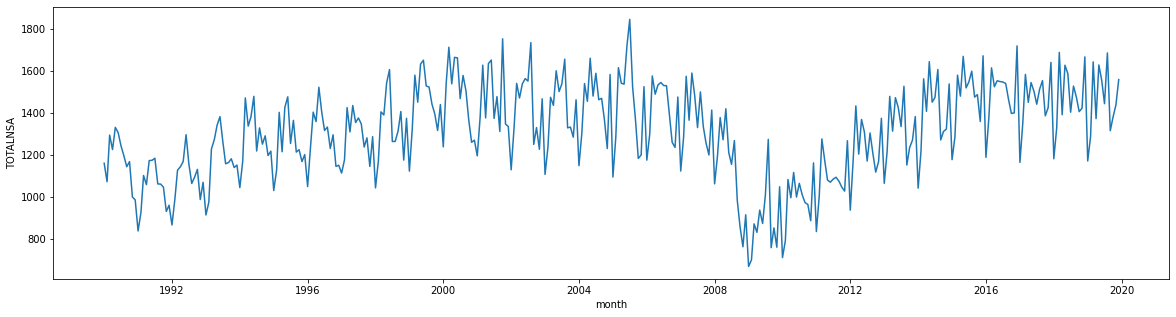

In [3]:
# plot time series
plt.figure(figsize=(20,5))
ax = sns.lineplot(x='month', y='TOTALNSA', data=auto_data)
#plt.xticks(data['month'])

The plot of auto sales tells us several things:
- Auto sales is cyclical with an annual cycle, with summer being the peak season while winter being the slow season. Any analysis would require a seasonality component being incorporated.
- There is a strong rebound post-recession, represented by much stronger trend of growth compared to pre-recession. However, such trend reversed after 2015-16.

It is tempting to think that economy factors (such as GDP or Disposable Income) are important drivers of auto sales, which is partially true during a recession. However, the match is not as strong before the recession. <br> 
<br>
One of the reasons could be the very high vehicle ownership in U.S. ([source](https://static.america.gov/uploads/sites/8/2016/04/You-Asked-Series_Does-Everyone-in-America-Own-a-Car_English_Lo-Res_508.pdf)), meaning the U.S. auto market is a very saturated one to start with for durable goods like vehicles. <br>
<br>
The mismatch between the trend of endogenous and exogenous series could be a risk for inaccurate forecast.

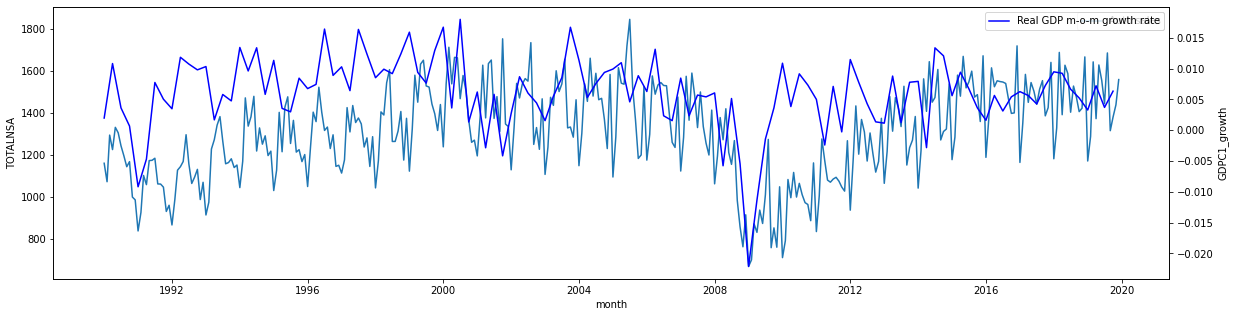

In [4]:
# compare trend of GDP growth with auto sales
gdp_data = pd.read_csv(Path('..') / 'data' / 'auto_sales' / 'monthly_gdpc1.csv')
gdp_data['month'] = pd.to_datetime(gdp_data['DATE']).dt.date
gdp_data['GDPC1'] = gdp_data['GDPC1'].shift(1) # shift by one to ensure month match

gdp_data['GDPC1_growth'] = gdp_data['GDPC1'].diff() / gdp_data['GDPC1']

auto_sales_range = (auto_data['month'].min(), auto_data['month'].max())
gdp_data_plot = gdp_data[ (gdp_data['month'] >= auto_sales_range[0]) & (gdp_data['month'] <= auto_sales_range[1]) ]

# plot
plt.figure(figsize=(20,5))
ax1 = sns.lineplot(x='month', y='TOTALNSA', data=auto_data, label='Auto sales')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='month', y='GDPC1_growth', data=gdp_data_plot, 
                    color='b', label='Real GDP m-o-m growth rate')
plt.legend()

### Decomposing auto sales data
As mentioned earlier, there is clearly both cyclical and trend components in the auto sales time series. Here let's use `seasonal_decompose` function in `statsmodels.tsa.seasonal` library to automatically decompose it. <br>

The residuals are stationary based on Dickey-Fuller test. Given the small p-value, we reject the null hypothest (that there is a unit root) and conclude that the series is stationary. The function a decent job decomposing cyclical effects and trend.

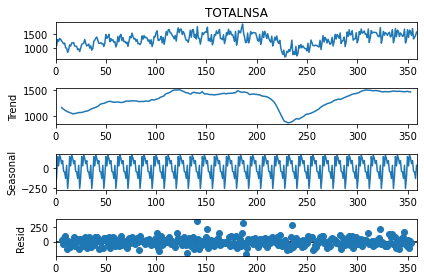

In [5]:
decompose_results = tsa.seasonal.seasonal_decompose(auto_data['TOTALNSA'], model='additive', period=12)

_ = decompose_results.plot() # assign to a throwaway variable to avoid return duplicate plot

In [6]:
# test whether the residuals are stationary
resid_test_result = sm.tsa.stattools.adfuller(list(filter(lambda x: x==x, decompose_results.resid)))
print('ADF statistic: %f' % resid_test_result[0])
print('p-value: %f' % resid_test_result[1])

ADF statistic: -6.576739
p-value: 0.000000


## Evaluate benefit of the stimulus
The rebate program only lasted for two months, and it is unlikely that the program would have lagging effects after it ended (as the incentive is gone). Therefore, its impact can be limited to the difference expected vs actual sales during July to August 2009. To evaluate the program, we need to:
- Predict sales during Jul to Aug as if there was no stimulus program, and calculate the difference of predicted sales and actual sales.
- Estimate incremental auto sales revenue, and compare with cost of the program.

### Forecasting car sales as if there was no stimulus
Based on exploratory analysis, a SARIMAX model seems to be an appropriate starting point for modeling. It uses 4 extra orders to handle seasonality, and allow exogenous factor, which is crucial for this dataset given the presence of recession. 


First, we select data prior to Jul 2009 for modeling. We further split it into trainining and validation (split date: )

In [7]:
# GDP is quarterly; use linear interpolation to switch to monthly
gdp_data = pd.read_csv(Path('..') / 'data' / 'auto_sales' / 'monthly_gdpc1.csv')
gdp_data['month'] = pd.to_datetime(gdp_data['DATE']).dt.date
gdp_data['GDPC1'] = gdp_data['GDPC1'].shift(1) # shift by one to ensure month match
gdp_interpolate = gdp_data[['month','GDPC1']]

# linear interpolate GDP data (from quarterly to monthly)
gdp_interpolate['month'] = pd.to_datetime(gdp_interpolate['month']).dt.to_period('M')
gdp_interpolate = gdp_interpolate.set_index('month').resample('M').interpolate().reset_index()
gdp_interpolate['month'] = pd.to_datetime(gdp_interpolate['month'].astype(str)).dt.date

gdp_interpolate['GDPC1_growth'] = gdp_interpolate['GDPC1'].diff() / gdp_interpolate['GDPC1']

In [8]:
model_data = auto_data[ auto_data['month'] < pd.to_datetime('2009-07-01') ]

# using 2 years of data as validation
train_validate_cutoff = '2007-01-01'
earliest_date = model_data['month'].min()
latest_date = model_data['month'].max()
train_ts = model_data[ model_data['month'] <= pd.to_datetime(train_validate_cutoff) ]['TOTALNSA'].values
validate_ts = model_data[ model_data['month'] > pd.to_datetime(train_validate_cutoff) ]['TOTALNSA'].values

# using GDP growth as exogenous factors
train_exog = gdp_interpolate[ (gdp_interpolate['month'] >= earliest_date) & (gdp_interpolate['month'] <= pd.to_datetime(train_validate_cutoff)) ]['GDPC1_growth'].values
validate_exog = gdp_interpolate[ (gdp_interpolate['month'] > pd.to_datetime(train_validate_cutoff)) & (gdp_interpolate['month'] <= latest_date) ]['GDPC1_growth'].values


In [9]:
def sarimax_gridsearch(train_ts, train_exog, validate_ts, validate_exog, all_param):
    """Grid search for SARIMAX models.
    Args:
        train_ts (array-like): time series for training.
        train_exog (array-like): exogenous factors for training period. 
        validate_ts (array-like): time series for validation.
        validate_exog (array-like): exogenous factors for validation period.
        all_param (list): list of parameters to search. (p, d, q) x (P, D, Q)
    
    Returns:
        results (dict): SARIMAXResults object of each model.
        aic (dict): AIC of each model.
        parameters (dict): parameters of each model.
        mapes (dict): Validation MAPE of each model.
    """
    results, aic, parameters, mapes = {}, {}, {}, {}
    for param in all_param:
        try:
            model_name = 'SARIMAX {}x{}'.format(param[0], param[1])
            model = tsa.statespace.sarimax.SARIMAX(train_ts,
                            exog=train_exog,
                            order=param[0],
                            seasonal_order=param[1])
            res = model.fit()

            # get validation predictions
            validate_pred = res.get_prediction(start=1, end=len(validate_ts), exog=validate_exog)
            validate_predicted_mean = validate_pred.predicted_mean
            validate_pred_ci = validate_pred.conf_int()

            # calculate MAPE
            mape = np.mean(abs(validate_predicted_mean - validate_ts)/validate_ts)

            results[model_name] = res
            aic[model_name] = res.aic 
            parameters[model_name] = param
            mapes[model_name] = mape

            print(f'{model_name} - AIC:{res.aic:.2f}; MAPE:{mape:.2%}')
        except Exception as e: # handle failed to converge errors
            print(e)
            continue
            
    return results, aic, parameters, mapes

In [10]:
# set parameter range
p, d, q = range(0,3), [1], range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[12]

# list of all parameter combos
pdq = list(product(p, d, q))
seasonal_pdq = list(product(P, D, Q, s))
all_param = list(product(pdq, seasonal_pdq))

results, aic, parameters, mapes = sarimax_gridsearch(train_ts, train_exog, validate_ts, validate_exog, all_param)

SARIMAX (0, 1, 0)x(0, 1, 0, 12) - AIC:2394.16; MAPE:18.67%
SARIMAX (0, 1, 0)x(0, 1, 1, 12) - AIC:2354.46; MAPE:18.27%
SARIMAX (0, 1, 0)x(0, 1, 2, 12) - AIC:2348.29; MAPE:18.40%
SARIMAX (0, 1, 0)x(1, 1, 0, 12) - AIC:2376.17; MAPE:18.39%
SARIMAX (0, 1, 0)x(1, 1, 1, 12) - AIC:2349.43; MAPE:18.37%
SARIMAX (0, 1, 0)x(1, 1, 2, 12) - AIC:2350.02; MAPE:18.40%
SARIMAX (0, 1, 0)x(2, 1, 0, 12) - AIC:2361.27; MAPE:18.39%
SARIMAX (0, 1, 0)x(2, 1, 1, 12) - AIC:2350.42; MAPE:18.40%
SARIMAX (0, 1, 0)x(2, 1, 2, 12) - AIC:2350.98; MAPE:18.42%
SARIMAX (0, 1, 1)x(0, 1, 0, 12) - AIC:2332.39; MAPE:17.69%
SARIMAX (0, 1, 1)x(0, 1, 1, 12) - AIC:2277.63; MAPE:17.86%
SARIMAX (0, 1, 1)x(0, 1, 2, 12) - AIC:2277.68; MAPE:17.82%
SARIMAX (0, 1, 1)x(1, 1, 0, 12) - AIC:2302.53; MAPE:17.85%
SARIMAX (0, 1, 1)x(1, 1, 1, 12) - AIC:2277.88; MAPE:17.82%
SARIMAX (0, 1, 1)x(1, 1, 2, 12) - AIC:2278.70; MAPE:17.84%
SARIMAX (0, 1, 1)x(2, 1, 0, 12) - AIC:2287.14; MAPE:17.92%
SARIMAX (0, 1, 1)x(2, 1, 1, 12) - AIC:2279.64; MAPE:17.8

In [11]:
print('Model with minimum MAPE: ', min(mapes, key=mapes.get))

Model with minimum MAPE:  SARIMAX (0, 1, 2)x(0, 1, 0, 12)


In [12]:
print('Model with minimum AIC: ', min(aic, key=aic.get))

Model with minimum AIC:  SARIMAX (2, 1, 2)x(0, 1, 2, 12)


The model that gives the lowerst MAPE is chosen, as the goal of analysis relies on the prediction. Still, we need to check model fit through diagnosis plots - looks like most of the residuals are in good shape.

In [13]:
# use selected model to re-train on entire data
model_ts = np.concatenate([train_ts, validate_ts])
model_exog = np.concatenate([train_exog, validate_exog])

sarimax_model = tsa.statespace.sarimax.SARIMAX(model_ts,
                            exog=model_exog,
                            order=(0, 1, 2),
                            seasonal_order=(0, 1, 0, 12))
sarimax_result = sarimax_model.fit()

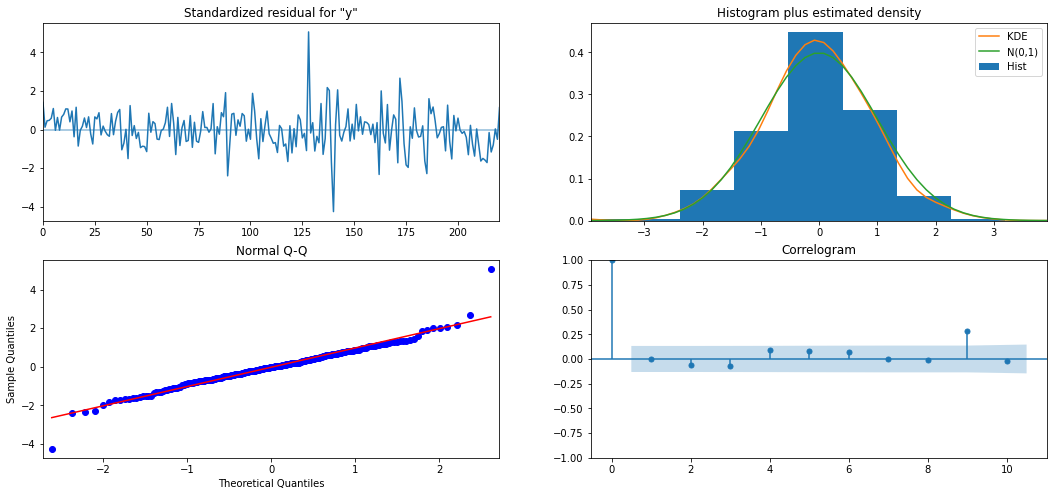

In [14]:
# plot model diagnosis
_ = sarimax_result.plot_diagnostics(figsize=(18, 8))


In [15]:
pred = sarimax_result.get_prediction(start=1, end=2, exog=validate_exog)

actu = auto_data[ (auto_data['month'] == pd.to_datetime('2009-07-01'))|(auto_data['month'] == pd.to_datetime('2009-08-01')) ]['TOTALNSA'].values

incremental_sales = sum(actu) - sum(pred.predicted_mean)

print(f'Incremental sales during Jul - Aug 2009: {incremental_sales:.1f} (thousands units)')

Incremental sales during Jul - Aug 2009: 61.4 (thousands units)


### Cost-benefit analysis for the program

According to the prediction, C.A.R.S program was able to generate incremental sales of 62k vehicles during two months. Compare to 700k vehicles sold through the program, it seems that majority of the sales are not incentivized by the program, but comes from customers who would buy cars anyways.<br>
<br>
Using average new car price of 2009 ([$28,000](https://www.roadandtrack.com/car-culture/buying-maintenance/a27016809/new-car-msrp-increase-2019/)), we estimate the program generated \$1.8 billion incremental revenue for car industry. However, the cost of the the program was around $3 billion, indicating a $1.2 billion deficit. Not a good investment!

## Next steps
Of course, the forecast and analysis is quite rudimentary and have much to improve. Key improvement areas are:
<br>
- Modeling and forecast. Current MAPE is 18%, which is far from satisfatory. It may be improved with: <br>
    (1) better exogenous factors. GDP data used here is interpolated from monthly data. Also, GDP growth might not be the most appropriate exogenous factor, especially when car ownership in U.S. is so high. <br>
    (2) better models. Try more complex models including deep learning models (e.g.LSTM) and causal inferencing models (e.g.Bayesian Structured Time Series, can potentially handle more exogenous factors) <br>
<br>
- Cost-benefit analysis. The current cost/benefit calculation is just napkin maths with limited public data available. More detailed data is needed for better analysis. 